
Cluster to Work, also Cluster to Manifestation (exact duplicates)


Initial Clustering to Manifestation

- create unassigned_docs list
- while len(unassigned_docs) > 0:
    - create a manifestationId set, assign a unique identifier
    - set target = random(unassigned_docs)
    - add target to manifestationId
    - add all of target's high confidence (>x% likelihood) SWSM relationships to manifestationId
    - remove all items in manifestationId set from unassigned docs
    
Agglomeration
- for each manifestationId
    - while True
        - open parquet files for all of it's volumes
        - join ManifestationId references, so htids are represented by ManifestationIds
        - sort target/source alphabetically (flip CONTAINS probs)
        - sum probs for related vols, count number of parquet inputs
        - (do something that acknowledges high avg confidence of relationship, while including degrees of freedom)
        - (possibly - there may need to be a culling step, where volumes in manifestationId that look dissimilar from the other SWSMs may need to be spun off)
        - Merging: are there high confidence SWSM manifestations that need to be merged in?
            - if False: break
            - if True: add volumes from second manifestationId to target manifestationId, and continue
           
    
- choose random doc from pile

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import os
from htrc_features import utils
import numpy as np
import duckdb
import shutil 

from sknetwork.visualization import svg_graph
from IPython.display import SVG

In [3]:
from compare_tools.work_clustering import (high_conf_predictions, cluster_all, merge_labels,
                                           join_clustered_predictions, process_label_stats)

## Using DuckDB

In [5]:
con = duckdb.connect('/data/saddl/full.duckdb', read_only=True, config={'max_memory':'16G', 'threads':4})
con.execute("CREATE INDEX htid_idx ON meta (htid);")
con.execute("CREATE INDEX target_clean_idx ON clean_predictions (target);")

### Network clustering 

Here's the strategy.

Working toward a manifestation ID:
- clustering high confidence (>X%) SWSM relationships
- folding inferences by cluster, then lowering X and repeating

This multi-pass approach tries to be careful in expanding cluster membership. The confidence of a single book<->book relationship can be erroneously high, but after a pass or two, the confidence of a set of like-books being the same as SWSM would hopefully be more reliable.

In [6]:
%%time
# return high-conf swsm, exclude reciprocal redundance lines (where target < candidate)
swsm_inferences = high_conf_predictions(con)
print(swsm_inferences.shape[0])
swsm_inferences.sample(3)

93489
CPU times: user 649 ms, sys: 405 ms, total: 1.05 s
Wall time: 1.05 s


,target,candidate,swsm
76284,uc1.31822009557950,uc1.31822009557992,0.990631
50324,mdp.39015087627819,nyp.33433077855348,0.994799
17590,mdp.39015001485815,mdp.39015001485997,0.994962


In [25]:
cluster_labels = cluster_all(con, swsm_inferences, save_to='/tmp/manifestation1.parquet')
cluster_labels.head()

,man_id,htid
0,8202,aeu.ark:/13960/t0000kn86
1,1829,aeu.ark:/13960/t0000mg10
2,4627,aeu.ark:/13960/t3cz41n3k
3,2880,aeu.ark:/13960/t3fx7ws0p
4,11678,aeu.ark:/13960/t3mw3453n


In [19]:
join_clustered_predictions(con, '/tmp/manifestation1.parquet', '/tmp/manifestation1_predictions.parquet', 'man_id')
con.execute("SELECT COUNT(*) FROM '/tmp/manifestation1_predictions.parquet'").fetch_df()

,count_star()
0,15903100


There we have it, our first pass of SWSM clusterings. Now, repeat a few times, lowering the confidence threshold, to derive the final SADDL id.

### Subsequent Manifestation Passes

Simply for completeness, this code starts from the first pass, ignore the cells run above.

In [ ]:
# below 76%, we'll assume a 'weak' label and won't merge.
prob_steps = np.concatenate([np.arange(99, 85, -1)/100, np.arange(85, 75, -2)/100])
label_inference_file = None
label_reference_file = None
last_id_col = None

#label_reference_file = final_reference_file # Temp, for resuming post crash
#label_inference_file = final_inference_file 
#last_id_col = 'man_id'

for name, fields in [('manifestation', 'swsm'), ('work', ['swsm', 'swde'])]:
    
    print("Folding", name)
    
    for i, min_prob in zip(range(1, len(prob_steps)+1), prob_steps):
        previous_label_inference_file = label_inference_file if label_inference_file else 'clean_predictions'
        previous_reference_file = label_reference_file
        label_inference_file = f"/tmp/{name}{i}_predictions.parquet"
        label_reference_file = f"/tmp/{name}{i}.parquet"
        id_col = f"{'man' if name == 'manifestation' else name}_id"
        
        print(name, i, min_prob)
        inferences = high_conf_predictions(con, field=fields, from_table=previous_label_inference_file, min_probability=min_prob)
        if inferences.empty:
            raise Exception('\tNo matches. Try lowering threshold')
        print("\tRow count matching min_probability target:", len(inferences))
        
        cluster_labels = cluster_all(con, inferences, id_col,
                                    from_table=previous_label_inference_file)
        print("\tUnique clusters: ", len(cluster_labels[id_col].unique()))
        
        if previous_reference_file:
            intermediate_label_reference_file = f"/tmp/{name}{i}-id2id.parquet"
            cluster_labels.to_parquet(intermediate_label_reference_file)
            merge_labels(con, previous_reference_file, intermediate_label_reference_file, id_col, last_id_col, debug=False).to_parquet(label_reference_file)
            os.remove(intermediate_label_reference_file)
            os.remove(previous_reference_file)
        else:
            cluster_labels.rename(columns={'label':id_col}).to_parquet(label_reference_file)
        last_id_col = id_col

        df = join_clustered_predictions(con, label_reference_file, label_inference_file, id_col)
        
        if previous_label_inference_file.endswith('.parquet') and '/tmp' in previous_label_inference_file:
            os.remove(previous_label_inference_file)
        
        print("\tNumber of inference labels: ", df['Count'].iloc[0])

    # Move our final SADDL manifestation or work files out of /tmp
    final_inference_file = f'/data/saddl/saddl_{name}_predictions.parquet'
    final_reference_file = f'/data/saddl/saddl_{name}_reference.parquet'
    shutil.move(label_inference_file, final_inference_file)
    shutil.move(label_reference_file, final_reference_file)
    label_inference_file, label_reference_file = final_inference_file, final_reference_file

## Copy Final Tables to DB

In [47]:
#del con
con = duckdb.connect('/data/saddl/full.duckdb', read_only=False, config={'max_memory':'16G', 'threads':4})

Insert the cluster reference to the DB. This has both the SADDL Manifestation ID and SADDL Work ID for every single relevant htid.

In [127]:
# Don't save intermediate ids, those can always be referenced later from the file.
con.execute("DROP TABLE IF EXISTS clusters")
con.execute(f"CREATE TABLE clusters AS (SELECT htid, work_id, man_id as man_id FROM '/data/saddl/saddl_work_reference.parquet' ORDER BY htid)")
con.execute("SELECT * FROM clusters USING SAMPLE 4").fetch_df()

,htid,work_id,man_id
0,mdp.39015086694745,45739,13819
1,inu.30000046329086,741745,813269
2,mdp.39015018625247,155282,138022
3,hvd.hnl1h4,215096,206984


Save label-specific stats on serials and gov docs. We eventually want to ignore labels that are predominantly either.

In [130]:
## Look at label information - membership counts, as well as serial and gov doc counts.
con.execute("DROP TABLE IF EXISTS work_stats")
process_label_stats(con, label_reference_file, out_table='work_stats', id_col='work_id', print_query=True)
df = con.execute("SELECT * FROM work_stats WHERE label_count > 100 ORDER BY work_id LIMIT 10").fetch_df()
df

CREATE TABLE work_stats AS (
        SELECT *, gov_count/CAST(label_count AS float) as gov_prop, 
            serial_count/CAST(label_count AS float) as serial_prop
        FROM (
            SELECT work_id, 
                    COUNT(*) as label_count,
                    COUNT(*) filter (where us_gov_doc_flag == True) as gov_count, 
                    COUNT(*) filter (where bib_fmt == 'SE') as serial_count
            FROM "/data/saddl/saddl_work_reference.parquet" as clusters 
            JOIN meta on clusters.htid == meta.htid 
            GROUP BY work_id
            ) label_stats
    )


,work_id,label_count,gov_count,serial_count,gov_prop,serial_prop
0,0,14020,13214,3534,0.942511,0.252068
1,1,869,837,41,0.963176,0.047181
2,2,590,573,31,0.971186,0.052542
3,3,311,303,4,0.974277,0.012862
4,4,2126,0,25,0.000000,0.011759
5,6,411,0,33,0.000000,0.080292
6,7,433,0,22,0.000000,0.050808
7,10,641,0,34,0.000000,0.053042
8,23,260,0,0,0.000000,0.000000
9,24,302,0,0,0.000000,0.000000


Save manifestation and work relationships, as `manifestation_predictions` and `work_predictions`.

In [131]:
%%time
con.execute("DROP TABLE IF EXISTS work_predictions")
con.execute("DROP TABLE IF EXISTS manifestation_predictions")
con.execute('CREATE TABLE work_predictions as (SELECT * FROM "/data/saddl/saddl_work_predictions.parquet" ORDER BY target)')
con.execute('CREATE TABLE manifestation_predictions as (SELECT * FROM "/data/saddl/saddl_manifestation_predictions.parquet" ORDER BY target)')

CPU times: user 19.7 s, sys: 11.2 s, total: 30.9 s
Wall time: 33.5 s


**Optional for data transfer**: Export the database without the giant predictions table. DUCKDB doesn't do VACUUM yet, so we [`EXPORT DATABASE`](https://duckdb.org/docs/sql/statements/export), then delete the `predictions` table and sql references. The resulting folder can be imported with [`IMPORT DATABASE`](https://duckdb.org/docs/sql/statements/export).

In [5]:
con = duckdb.connect('/data/saddl/full.duckdb', read_only=False)
con.execute("EXPORT DATABASE '/tmp/saddl-db-export' (FORMAT PARQUET)").fetch_df()
!rm /tmp/saddl-db-export/[0-9]_predictions.parquet
!grep -v 'COPY predictions' /tmp/saddl-db-export/load.sql >/tmp/saddl-db-export/load.sql.tmp
!mv /tmp/saddl-db-export/load.sql.tmp /tmp/saddl-db-export/load.sql
!grep -v 'CREATE TABLE predictions' /tmp/saddl-db-export/schema.sql >/tmp/saddl-db-export/schema.sql.tmp
!mv /tmp/saddl-db-export/schema.sql.tmp >/tmp/saddl-db-export/schema.sql

mv: missing destination file operand after ‘/tmp/saddl-db-export/schema.sql.tmp’
Try 'mv --help' for more information.


In [17]:
!rm /data/saddl/full_succinct.duckdb

In [18]:
con = duckdb.connect('/data/saddl/full_succinct.duckdb', read_only=False)

In [19]:
con.execute("IMPORT DATABASE '/tmp/saddl-db-export'").fetch_df()

,Count
0,988013


In [20]:
!ls -lh /data/saddl/*db

-rw-r--r--. 1 peter.organisciak domain users  39G Jul 16 10:28 /data/saddl/full.duckdb
-rw-r--r--. 1 peter.organisciak domain users 9.7G Jul 16 11:54 /data/saddl/full_succinct.duckdb
-rw-r--r--. 1 peter.organisciak domain users  12K Jul 16 10:27 /data/saddl/full_succinct-temp.duckdb
-rw-r--r--. 1 peter.organisciak domain users 7.0G Jul 26  2020 /data/saddl/meta.db
-rw-r--r--. 1 peter.organisciak domain users 101M Nov  6  2019 /data/saddl/meta_testset.db


## View tables

In [82]:
con.execute('SELECT * FROM clusters LIMIT 4').fetch_df()

,htid,work_id,man_id
0,aeu.ark:/13960/t0000bj8z,5117,852475
1,aeu.ark:/13960/t0000cm9r,469788,506730
2,aeu.ark:/13960/t0000ds1j,341293,360099
3,aeu.ark:/13960/t0000ds9d,498638,539540


In [81]:
con.execute(f"SELECT * FROM work_predictions WHERE count > 25 LIMIT 4").fetch_df()

,target,candidate,swsm,swde,wp_dv,partof,contains,overlaps,author,simdiff,grsim,randdiff,count
0,0,0,0.150380,0.553899,0.253244,0.005854,0.005854,0.000499,0.023055,0.007055,0.000099,0.000061,1907216
1,0,6051,0.017547,0.382129,0.244456,0.002106,0.003367,0.000296,0.087038,0.249500,0.009700,0.003860,32
2,0,11334,0.115998,0.214632,0.585600,0.001828,0.000992,0.000106,0.009676,0.070144,0.000517,0.000505,360
3,0,4043,0.003149,0.278941,0.632094,0.001609,0.001349,0.001210,0.041524,0.039684,0.000075,0.000365,50


In [87]:
con.execute(f"SELECT * FROM manifestation_predictions  WHERE count > 25 LIMIT 4").fetch_df()

,target,candidate,swsm,swde,wp_dv,partof,contains,overlaps,author,simdiff,grsim,randdiff,count
0,0,9649,0.018986,0.001905,0.973257,0.001499,0.001498,0.000077,0.002113,0.000607,0.000054,0.000005,28
1,0,26369,0.176398,0.011137,0.776330,0.006592,0.004765,0.000746,0.023151,0.000505,0.000347,0.000028,68
2,0,82864,0.077821,0.000995,0.913997,0.001235,0.001746,0.000106,0.003739,0.000306,0.000036,0.000020,26
3,0,37013,0.096150,0.001712,0.865297,0.005309,0.002526,0.000593,0.013942,0.012499,0.001833,0.000139,28


In [89]:
## See the internal similarity between books of the same cluster. This can be a 'group coherence' score.
## Our merging process could one day drop books that act to the detrminent of this score.

# Note that all the high-inference stats are for labels that we'll eventually ignore because of serial and gov doc counts.
df = con.execute(f"SELECT target, swsm, count FROM work_predictions WHERE target == candidate LIMIT 2").fetch_df()
df.head()

,target,swsm,count
0,0,0.150380,1907216
1,1,0.045787,177028


In [ ]:
df = con.execute('''
SELECT * FROM '/tmp/label_stats.parquet'
JOIN (
    SELECT target, swsm, count
    FROM '/tmp/manifestation22_predictions.parquet'
    WHERE target == candidate)
''').fetch_df()
con.execute(f"SELECT target, swsm, count FROM '{label_inference_file}' WHERE target == candidate LIMIT 1").fetch_df()
df

In [114]:
con.execute('''
SELECT target, swsm, swde, wp_dv, count, gov_prop, serial_prop
FROM work_predictions
JOIN (
    SELECT *
    FROM work_stats
    WHERE gov_prop <0.5 AND serial_prop <0.5
    ) stats ON target==work_id
WHERE target == candidate AND count > 100
USING SAMPLE 10''').fetch_df()

,target,swsm,swde,wp_dv,count,gov_prop,serial_prop
0,857,0.069234,0.539119,0.075537,6540,0.0,0.012270
1,34264,0.714298,0.245781,0.022272,112,0.0,0.000000
2,6256,0.374086,0.602155,0.018498,352,0.0,0.000000
3,65172,0.951549,0.047198,0.000978,296,0.0,0.076923
4,4391,0.142235,0.761733,0.040033,492,0.0,0.000000
5,4602,0.216846,0.514057,0.255953,336,0.0,0.000000
6,1618,0.383355,0.471545,0.078287,204,0.0,0.000000
7,12691,0.434770,0.496946,0.013177,108,0.0,0.000000
8,7209,0.321935,0.656140,0.013505,220,0.0,0.000000
9,7943,0.167073,0.781904,0.002553,136,0.0,0.000000


In [99]:
con.execute("SELECT * FROM '/data/saddl/saddl_work_reference.parquet' LIMIT 1").fetch_df()

,work_id,htid,man_id_pass1,man_id_pass2,man_id_pass3,man_id_pass4,man_id_pass5,man_id_pass6,man_id_pass7,man_id_pass8,...,work_id_pass33,work_id_pass34,work_id_pass35,work_id_pass36,work_id_pass37,work_id_pass38,work_id_pass39,work_id_pass40,work_id_pass41,work_id_pass42
0,94316,aeu.ark:/13960/t0000kn86,12250,16676,19973,22785,25506,27995,30336,32565,...,91529,91777,92042,92226,92437,92702,92949,93168,93455,93778


In [110]:
# See the reverse history of how the labels the members of a specific label where in previously
# This helps provide a sense as to when the group membership got too big too merge with other things
label = 207
con.execute("SELECT COUNT(DISTINCT work_id), " + ",".join([f"COUNT(DISTINCT work_id_pass{x})" for x in range(42,22, -1)]) + f" FROM '/data/saddl/saddl_work_reference.parquet' WHERE work_id == {label}").fetch_df()

,count(work_id),count(work_id_pass42),count(work_id_pass41),count(work_id_pass40),count(work_id_pass39),count(work_id_pass38),count(work_id_pass37),count(work_id_pass36),count(work_id_pass35),count(work_id_pass34),...,count(work_id_pass32),count(work_id_pass31),count(work_id_pass30),count(work_id_pass29),count(work_id_pass28),count(work_id_pass27),count(work_id_pass26),count(work_id_pass25),count(work_id_pass24),count(work_id_pass23)
0,1,3,3,5,6,12,12,13,14,15,...,19,21,21,22,22,22,22,26,27,28


In [118]:
con.execute('''
SELECT * FROM clusters
JOIN (
    SELECT * FROM work_predictions WHERE target == candidate
    ) inner_predictions ON inner_predictions.target == clusters.work_id
WHERE work_id == 4602
''').fetch_df()

,htid,work_id,man_id,target,candidate,swsm,swde,wp_dv,partof,contains,overlaps,author,simdiff,grsim,randdiff,count
0,uc1.b3567393,4602,480914,4602,4602,0.216846,0.514057,0.255953,0.000454,0.000454,0.000086,0.00191,0.009535,0.000705,1.418122e-07,336
1,uc1.b3567392,4602,365909,4602,4602,0.216846,0.514057,0.255953,0.000454,0.000454,0.000086,0.00191,0.009535,0.000705,1.418122e-07,336
2,uc1.b3332892,4602,7581,4602,4602,0.216846,0.514057,0.255953,0.000454,0.000454,0.000086,0.00191,0.009535,0.000705,1.418122e-07,336
3,uc1.b3332065,4602,803218,4602,4602,0.216846,0.514057,0.255953,0.000454,0.000454,0.000086,0.00191,0.009535,0.000705,1.418122e-07,336
4,uc1.b3332063,4602,625894,4602,4602,0.216846,0.514057,0.255953,0.000454,0.000454,0.000086,0.00191,0.009535,0.000705,1.418122e-07,336
5,uc1.b3307960,4602,411452,4602,4602,0.216846,0.514057,0.255953,0.000454,0.000454,0.000086,0.00191,0.009535,0.000705,1.418122e-07,336
6,nyp.33433076052673,4602,19331,4602,4602,0.216846,0.514057,0.255953,0.000454,0.000454,0.000086,0.00191,0.009535,0.000705,1.418122e-07,336
7,nyp.33433076052632,4602,522692,4602,4602,0.216846,0.514057,0.255953,0.000454,0.000454,0.000086,0.00191,0.009535,0.000705,1.418122e-07,336
8,uc1.31970004904519,4602,1022,4602,4602,0.216846,0.514057,0.255953,0.000454,0.000454,0.000086,0.00191,0.009535,0.000705,1.418122e-07,336
9,nyp.33433075785547,4602,439802,4602,4602,0.216846,0.514057,0.255953,0.000454,0.000454,0.000086,0.00191,0.009535,0.000705,1.418122e-07,336


In [115]:
con.execute('''
SELECT clusters.htid, meta.title, meta.author, meta.description, meta.page_count, meta.access, meta.rights_date_used, meta.rights
FROM clusters
JOIN meta ON meta.htid == clusters.htid
WHERE work_id == 4602
''').fetch_df()

,htid,title,author,description,page_count,access,rights_date_used,rights
0,coo.31924013553866,"The wrong box, by Robert Louis Stevenson and L...","Stevenson, Robert Louis, 1850-1894.",NaN,276,allow,1907.0,pd
1,coo.31924013554013,Memories and portraits.,"Stevenson, Robert Louis, 1850-1894.",NaN,320,allow,1887.0,pd
2,hvd.32044090273996,The novels and tales of Robert Louis Stevenson.,"Stevenson, Robert Louis, 1850-1894.",v.17,350,allow,1902.0,pdus
3,hvd.32044093606879,The letters of Robert Louis Stevenson / edited...,"Stevenson, Robert Louis, 1850-1894.",v.4,440,allow,1911.0,pd
4,hvd.hn2dvk,"Memories and portraits, by Robert Louis Steven...","Stevenson, Robert Louis, 1850-1894.",NaN,328,allow,1898.0,pd
5,hvd.hn5clv,The wrong box; The ebb tide.,"Stevenson, Robert Louis, 1850-1894.",NaN,268,allow,1901.0,pd
6,hvd.hn5cmh,"Memories and portraits, by Robert Louis Steven...","Stevenson, Robert Louis, 1850-1894.",NaN,328,allow,1898.0,pd
7,hvd.hn65kt,Memories & portraits / by Robert Louis Stevenson.,"Stevenson, Robert Louis, 1850-1894.",NaN,324,allow,1907.0,pd
8,mdp.39015063961695,Memories and portraits. by Robert Louis Steven...,"Stevenson, Robert Louis, 1850-1894.",NaN,322,allow,1908.0,pd
9,mdp.39015066188494,The works of Robert Louis Stevenson.,"Stevenson, Robert Louis, 1850-1894.",v.30,376,deny,1925.0,und


In [ ]:
all_swsm = con.execute('''
SELECT target, candidate, swsm
FROM clean_predictions
''').fetch_df()
all_swsm

In [164]:
all_swsm[all_swsm.target.isin(test_list)].query('swsm > .9')

,target,candidate,swsm
482778,hvd.32044032306409,uc1.b3478820,0.992608
482789,hvd.32044032306409,hvd.32044090114356,0.992354
482793,hvd.32044032306409,mdp.39015039328920,0.992032
482800,hvd.32044032306409,hvd.32044090115510,0.992214
482804,hvd.32044032306417,uc1.b3478821,0.945130
...,...,...,...
16089775,uc1.b3478945,nyp.33433081899142,0.989076
16673511,uc1.b3646303,uc1.b3646304,0.932642
16673529,uc1.b3646304,uc1.b3646302,0.908225
16673532,uc1.b3646304,uc1.b3646303,0.932642


In [158]:
test_list = df.target.unique()

57


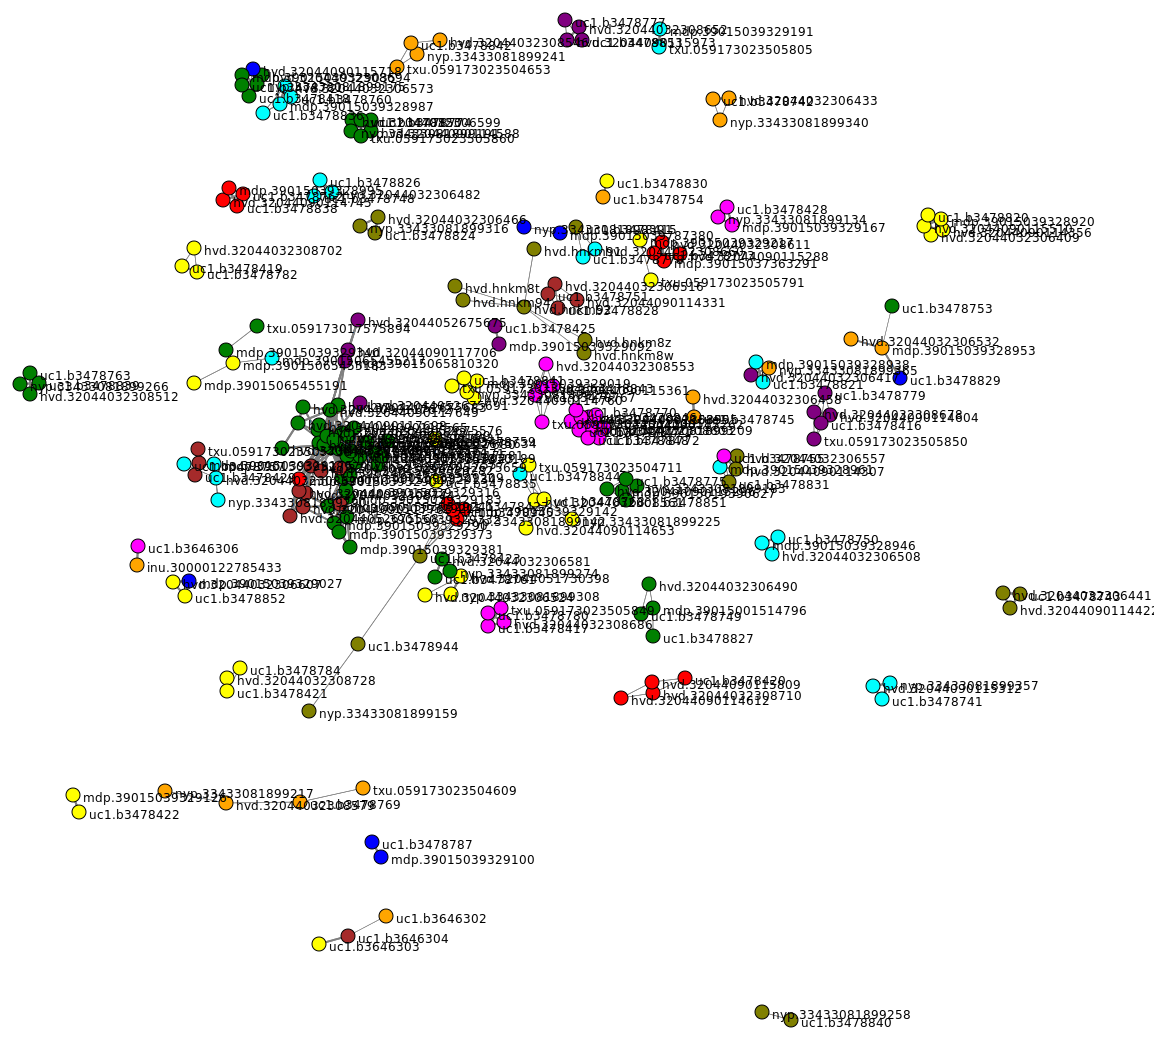

In [295]:
edge_list = list(all_swsm[all_swsm.target.isin(test_list)].query('swsm > .9').itertuples(index=False))
graph = convert_edge_list(edge_list, directed=False)

#clusterer = PropagationClustering(weighted=True, node_order='random', n_iter=20)
clusterer = Louvain()
labels = clusterer.fit_transform(graph.adjacency)
print(len(set(labels)))

image = svg_graph(graph.adjacency, labels=cluster_labels.set_index('htid').loc[graph.names].label.tolist(), names=graph.names, height=1000, width=1000, display_edge_weight=True, edge_width_max=2)
SVG(image)

In [296]:
df[taget]

,target,candidate,swsm,swde,wp_dv,partof,contains,overlaps,author,simdiff,grsim,randdiff,count
0,848,848,0.997553,2.041871e-03,0.000390,1.913790e-06,1.913790e-06,1.929335e-06,9.422271e-06,3.773572e-08,6.832857e-09,3.328873e-10,60.0
1,4106,4106,0.999948,2.634560e-05,0.000023,2.024286e-07,2.024286e-07,2.180152e-08,1.727124e-06,3.916963e-09,1.057361e-12,1.723933e-13,12.0
2,2788,2788,0.999919,3.592436e-06,0.000077,2.472562e-09,2.472562e-09,2.691159e-09,3.963869e-07,1.133252e-12,6.862409e-14,1.046095e-14,12.0
3,1769,1769,0.999989,1.525910e-06,0.000009,1.996589e-10,1.996589e-10,4.971023e-11,4.790663e-08,7.239071e-12,9.621985e-15,1.292275e-14,24.0
4,4592,4592,0.996765,5.021108e-04,0.002493,1.056352e-04,1.056352e-04,1.405128e-06,2.663723e-05,3.875261e-08,5.177567e-10,4.234621e-11,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21066,9183,9183,0.996777,1.840699e-03,0.001367,1.275969e-06,1.275969e-06,5.494823e-08,1.271721e-05,1.999225e-09,3.701061e-10,2.857989e-12,4.0
21067,14740,14740,0.983564,3.226333e-03,0.012184,4.997730e-05,4.997730e-05,9.834739e-06,8.881238e-04,2.780059e-05,1.071860e-07,2.542626e-08,4.0
21068,8852,8852,0.990368,1.235178e-05,0.009616,7.362478e-07,7.362478e-07,4.144828e-07,2.073934e-06,1.110017e-11,1.847385e-11,4.006991e-14,4.0
21069,14572,14572,0.993549,4.564678e-05,0.005862,1.261042e-04,1.261042e-04,4.102768e-05,2.502775e-04,9.875639e-08,4.049602e-11,6.560049e-10,4.0


In [75]:
df = con.execute('''
SELECT *
FROM clean_predictions
JOIN '/tmp/manifestation1.parquet' as clusters on clusters.htid == clean_predictions.target
JOIN '/tmp/manifestation1.parquet' as clusters2 on clusters2.htid == clean_predictions.candidate
WHERE clusters.label == 74 AND clusters2.label == 74
''').fetch_df()
df

,target,candidate,swsm,swde,wp_dv,partof,contains,OVERLAPS,author,simdiff,grsim,randdiff,relatedness,count,label,htid,__index_level_0__
0,hvd.32044052675550,mdp.39015065810031,0.177738,0.335133,0.445196,0.000162,0.000311,0.000474,0.040923,6.352219e-05,2.418797e-07,1.157618e-08,0.147364,2,74,mdp.39015065810031,48376
1,hvd.32044052675550,mdp.39015065810171,0.552742,0.027177,0.382328,0.000137,0.000315,0.000347,0.036942,1.309345e-05,4.995256e-08,7.863868e-09,0.170192,2,74,mdp.39015065810171,48378
2,hvd.32044052675550,mdp.39015065810163,0.929176,0.019823,0.046685,0.000164,0.000247,0.000157,0.003743,5.285740e-06,5.894049e-08,9.940621e-09,0.195439,2,74,mdp.39015065810163,48377
3,hvd.32044052675550,mdp.39015065587241,0.979617,0.008261,0.011821,0.000024,0.000017,0.000005,0.000255,8.956691e-07,4.531397e-08,7.587039e-09,0.198756,2,74,mdp.39015065587241,47868
4,hvd.32044052675550,mdp.39015065810015,0.868071,0.092862,0.036826,0.000045,0.000027,0.000018,0.002150,1.605065e-06,7.188585e-08,5.914865e-10,0.191910,2,74,mdp.39015065810015,48374
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1289,mdp.39015065810320,mdp.39015065810163,0.822541,0.015742,0.147706,0.002060,0.001744,0.002231,0.007923,5.278472e-05,1.091209e-07,9.435481e-08,0.188592,2,74,mdp.39015065810163,48377
1290,mdp.39015065810320,hvd.32044090117649,0.952864,0.030210,0.014381,0.000231,0.000065,0.000274,0.001971,2.970632e-06,5.852501e-07,5.290084e-09,0.197002,2,74,hvd.32044090117649,8057
1291,mdp.39015065810320,hvd.32044090117680,0.398590,0.077331,0.512997,0.000211,0.000217,0.000065,0.010570,1.902402e-05,1.203761e-07,8.015828e-09,0.163058,2,74,hvd.32044090117680,8059
1292,mdp.39015065810320,hvd.32044052675659,0.043620,0.396879,0.528494,0.000131,0.000646,0.000220,0.029866,1.423548e-04,8.451156e-08,9.975933e-09,0.140191,2,74,hvd.32044052675659,4974


In [72]:
df = con.execute('''
SELECT *
FROM clean_predictions
JOIN '/tmp/manifestation1.parquet' as clusters on clusters.htid == clean_predictions.target
WHERE label == 74
''').fetch_df()
df

,target,candidate,swsm,swde,wp_dv,partof,contains,OVERLAPS,author,simdiff,grsim,randdiff,relatedness,count,label,htid,__index_level_0__
0,hvd.32044032308744,mdp.39015039329134,0.327790,2.525294e-01,0.390572,0.002988,1.318129e-03,4.393473e-03,0.020393,1.615769e-05,3.755198e-08,8.276278e-09,0.157860,2,74,hvd.32044032308744,3603
1,hvd.32044032308744,mdp.39015039328938,0.004520,9.110764e-04,0.992396,0.000028,6.349009e-05,8.467307e-05,0.001405,5.918700e-04,6.102873e-07,2.259453e-08,0.140084,2,74,hvd.32044032308744,3603
2,hvd.32044032308744,hvd.32044052675568,0.991700,5.806212e-03,0.002418,0.000017,1.618762e-05,7.145776e-07,0.000041,2.246003e-07,1.727199e-08,1.221256e-09,0.199498,2,74,hvd.32044032308744,3603
3,hvd.32044032308744,hvd.32044090115395,0.001829,7.766263e-05,0.161247,0.833588,3.716999e-05,3.814735e-05,0.003096,3.569168e-05,2.068381e-06,4.861802e-05,0.123178,2,74,hvd.32044032308744,3603
4,hvd.32044032308744,mdp.39015065587241,0.903898,4.699913e-02,0.047630,0.000140,1.638507e-04,6.692111e-05,0.001101,1.422595e-06,8.299794e-08,1.511064e-08,0.194138,2,74,hvd.32044032308744,3603
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2394,mdp.39015065810320,hvd.32044090115262,0.000003,8.510628e-08,0.000007,0.999973,5.154054e-10,1.452127e-06,0.000016,9.511047e-08,3.598057e-11,1.284342e-09,0.119999,2,74,mdp.39015065810320,48380
2395,mdp.39015065810320,hvd.32044052675659,0.043620,3.968788e-01,0.528494,0.000131,6.462476e-04,2.204258e-04,0.029866,1.423548e-04,8.451156e-08,9.975933e-09,0.140191,2,74,mdp.39015065810320,48380
2396,mdp.39015065810320,hvd.32044090117581,0.322206,9.749332e-02,0.558237,0.002308,7.877669e-05,7.238081e-05,0.019502,1.022582e-04,8.394287e-08,1.860675e-09,0.157711,2,74,mdp.39015065810320,48380
2397,mdp.39015065810320,hvd.32044032308587,0.000004,3.136955e-05,0.000010,0.999911,4.142003e-09,1.093037e-06,0.000041,4.750957e-08,1.560622e-08,3.485743e-09,0.119999,2,74,mdp.39015065810320,48380


In [263]:
df = con.execute('''
SELECT title, access, author, page_count, rights, description, oclc_num, isbn, bib_fmt, rights_date_used, us_gov_doc_flag
FROM '/tmp/cluster1.parquet' as clusters 
JOIN meta on clusters.htid == meta.htid 
WHERE label == 159''').fetch_df()
df

,title,access,author,page_count,rights,description,oclc_num,isbn,bib_fmt,rights_date_used,us_gov_doc_flag
0,The elements of Euclid / Viz. the first six bo...,allow,Euclid.,460,pd,NaN,3658743,NaN,BK,1838.0,0
1,"The elements of Euclid, viz. the first six boo...",allow,Euclid.,540,pd,NaN,8125276,NaN,BK,1835.0,0
2,"The elements of Euclid : viz, the first six bo...",allow,Euclid.,532,pd,NaN,9234281,NaN,BK,1781.0,0
3,"The Elements of Euclid, viz. the first six boo...",allow,Euclid.,534,pd,NaN,8568385,NaN,BK,1825.0,0
4,"The Elements of Euclid, viz. the first six boo...",allow,"Simson, Robert, 1687-1768.",542,pd,NaN,66740633,NaN,BK,1835.0,0
5,"The Elements of Euclid, viz. The first six boo...",allow,"Simson, Robert, 1687-1768.",532,pd,NaN,23619371,NaN,BK,1781.0,0
6,"The Elements of Euclid, viz. the first six boo...",allow,"Simson, Robert, 1687-1768.",526,pd,NaN,9832308,NaN,BK,1829.0,0
7,The elements of Euclid; viz. the first six boo...,allow,"Simson, Robert, 1687-1768.",548,pd,NaN,66741202,NaN,BK,1827.0,0
8,"The Elements of Euclid, viz. the first six boo...",allow,"Simson, Robert, 1687-1768.",548,pd,NaN,14345298,NaN,BK,1806.0,0
9,"The Elements of Euclid, viz. The first six boo...",allow,"Simson, Robert, 1687-1768.",528,pd,NaN,66741174,NaN,BK,1804.0,0
